<a href="https://colab.research.google.com/github/Venture-Coding/Linkedin_Learning/blob/main/NLP/Basic_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNNs: Implementing A Basic RNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

### Read In & Split The Data

In [2]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [3]:
# Install keras
!pip install -U keras

In [4]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [6]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [7]:
# What do these sequences look like?
X_train_seq[0]

[1109, 77, 5, 662, 3836]

In [8]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [9]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 1109,   77,    5,  662, 3836], dtype=int32)

### Build Model

In [10]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [21]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          253056    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 262,465
Trainable params: 262,465
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [23]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 7s 34ms/step - loss: 0.3293 - accuracy: 0.8970 - precision_m: 0.3236 - recall_m: 0.2553 - val_loss: 0.1108 - val_accuracy: 0.9623 - val_precision_m: 0.9314 - val_recall_m: 0.6984
Epoch 2/10
140/140 [==============================] - 4s 30ms/step - loss: 0.0422 - accuracy: 0.9881 - precision_m: 0.9662 - recall_m: 0.9187 - val_loss: 0.0771 - val_accuracy: 0.9776 - val_precision_m: 1.0000 - val_recall_m: 0.8439
Epoch 3/10
140/140 [==============================] - 4s 30ms/step - loss: 0.0169 - accuracy: 0.9960 - precision_m: 0.9780 - recall_m: 0.9611 - val_loss: 0.0809 - val_accuracy: 0.9785 - val_precision_m: 1.0000 - val_recall_m: 0.8486
Epoch 4/10
140/140 [==============================] - 4s 31ms/step - loss: 0.0073 - accuracy: 0.9982 - precision_m: 0.9921 - recall_m: 0.9830 - val_loss: 0.0751 - val_accuracy: 0.9821 - val_precision_m: 1.0000 - val_recall_m: 0.8718
Epoch 5/10
140/140 [==============================] - 4s 30ms/step -

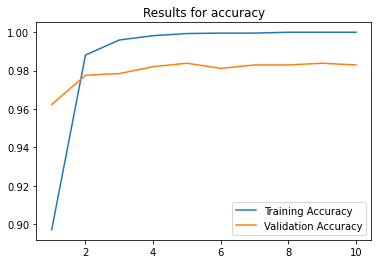

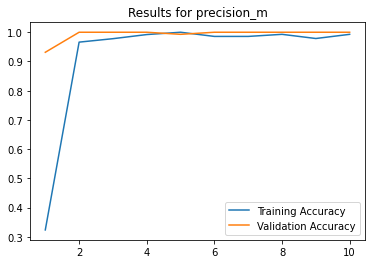

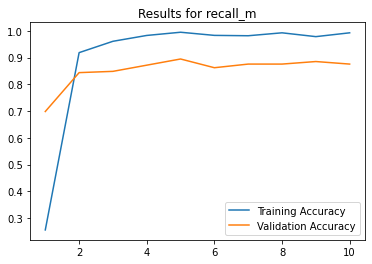

In [24]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

Since, we have a comparitively small dataset as well as 32 units in the hidden layers, we achieve high training accuracy pretty quickly and it is maintained throughout the epochs.